# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Chester et al. (2011,2015) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model setup
L = 0.01  # length of the plate
N = 25  # mesh density <= Chester et al. 2010 - 2011

mesh = UnitSquareMesh(N,N)

# Scale the mesh to the desired domain size
coordinates = mesh.coordinates()
for coord in coordinates:
    coord *= L

In [3]:
φ_o = 1.0       # initial polymer volume fraction
φ_swell = 0.35  # volumen fraction when the gel is swollen

In [4]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [5]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_phi = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
# W = FunctionSpace(mesh, MixedElement([element_u, element_mu]))
V, Q = FunctionSpace(mesh, element_u), FunctionSpace(mesh, element_phi)

In [6]:
# Define boundary conditions
class Left(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], 0)
class Right(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], L)
class Top(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], L)
class Bottom(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left = Left()
right = Right()
top = Top()
bottom = Bottom()

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
top.mark(boundaries, 3)
bottom.mark(boundaries,4)

In [7]:
# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(V.sub(1), Constant(0.0), bottom) 
u_bc_right = DirichletBC(V.sub(0), Constant(0.0), right)
u_bc_left = DirichletBC(V.sub(0), Constant(0.0), left)

# polymer volume fraction on the outer boundaries
phi_bc_top = DirichletBC(Q, Constant(φ_swell), top)
# phi_bc_left = DirichletBC(Q, Constant(φ_swell), left)
phi_bc_right = DirichletBC(Q, Constant(φ_swell), right)

# bcs = [u_bc_bottom, u_bc_right, mu_bc_bottom, mu_bc_right]
# bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]

# bc_u = [u_bc_bottom, u_bc_left] #u_bc_right]
# bc_phi = [phi_bc_top, phi_bc_right] #phi_bc_left]

bc_u = [u_bc_bottom, u_bc_left]#, u_bc_right]
bc_phi = [phi_bc_top, phi_bc_right] #phi_bc_left]

In [8]:
(du, dφ) = TrialFunction(V), TrialFunction(Q)
(v, q) = TestFunction(V), TestFunction(Q)

(u, φ) = Function(V), Function(Q)
(uold, φold) = Function(V), Function(Q)

# Create intial conditions and interpolate
# u_init = InitialConditions()
φ_init = Expression("0.75", degree=1)
φold.interpolate(φ_init)
φ.assign(φold)

In [9]:
# Model parameters
# Elasticity parameters
G0, χ = Constant(1.0e6), Constant(0.2)#Constant(0.1)
K = Constant(100.0e6)#Constant(3.93e6) # Bulk modulus
ΩK = Constant(100.0e6)
NΩ = Constant(1e-3)
Ω = Constant(1.7e-28)#Constant(1e-4)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
RT = Constant(8.31446261815324*298)
D = Constant(5e-8)#Constant(0.1)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)
gamma_s = Constant(10.)

µ_o = Constant(0.0)

alpha_r = 1.0 # Robin Boundary constant

In [10]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient
# C = F.T*F                             # Right Cauchy-Green tensor

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [11]:
# Cauchy stress
def T_(u,φ):
    return variable(inv(J(u))*(G0*(B(u) - (φ**(-2))*I)))# + (1/φ)*K*ln(J(u)*φ)*I))

# Piola stress - P = JTF^-T
def PK1(u,φ):
    # return variable(G0*(B(u) - (φ**(-2))*I)*inv(F(u).T)) # <= as in Chester et al. 2010
    return variable((G0*(B(u) - I) + K*(ln(J(u)*0.999*φ))*I)*inv(F(u).T))         # <= as in Chester et al. 2011
    # return variable((G0*(B(u) - I) + (1/φ)*K*ln(J(u)*φ)*I)*inv(F(u).T))         # <= as in Chester et al. 2015

# Chemical potential - µ
def µ_(u,φ):
    # return variable(µ_o + kBT*(ln(1 - 0.999*φ) + φ + χ*(φ**2)) + (Ω*G0)*(0.999/φ - 0.999*φ)) # <= as in Chester et al. 2010
    return variable((µ_o) + RT*(ln(1 - 0.999*φ) + φ + χ*(φ**2)) - (Ω*K)*ln(J(u)*φ)*φ) # <= as in Chester et al. 2011
    # return variable((µ_o) + RT*(ln(1 - 0.999*φ) + φ + χ*(φ**2)) - (Ω*K)*ln(J(u)) + (1/2)*(Ω*K)*ln(J(u)*0.999*φ)**2)  # <= as in Chester et al. 2015

In [12]:
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
dt = Constant(0.)

# Forces balance
Pi_mech_n = inner(PK1(u,φ), grad(v))*dx
Jac_n = derivative(Pi_mech_n, u, du) 

# Mass balance
D = 7.5e-8*kBT # <= this values works as well for Chester et al. 2011 and matches Chester et al. 2015
alpha_r = 10 # <= this works for Chester et al. 2015 
phi_form = (((φ - φold)/dt*q
            - (D/(kBT))*(dot(grad(φ),grad(µ_(u,φ))))*q 
            - (D/(kBT))*(dot(((φ**2)*((1 - 0.999*φ)/φ))*grad(µ_(u,φ)),grad(q))))*dx
            + alpha_r*(φ - φ_swell)*q*ds(2) + alpha_r*(φ - φ_swell)*q*ds(3))

Jac_phi = derivative(phi_form, φ, dφ)

In [13]:
# Time-stepping
Nincr = 250
# t = np.linspace(0, 50, Nincr+1)
t = np.logspace(-5, 1, Nincr+1)
Nx = 50
x = np.linspace(0, L, Nx)
µ_res = np.zeros((Nx, Nincr+1))

φ_res = np.zeros((Nx, Nincr+1))
φ_0_array = np.zeros((Nx, Nincr+1))
φ_05_array = np.zeros((Nx, Nincr+1))
φ_L_array = np.zeros((Nx, Nincr+1))

PK1_y_array = np.zeros((Nx, Nincr+1))
PK1xx0_array = np.zeros((Nx, Nincr+1))
PK1xxL_array = np.zeros((Nx, Nincr+1))

tolerance = 1e-6  # Set your own tolerance level
max_iterations = 10  # Set your own max number of iterations

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    print("t =", t_current) 
    dt.assign(dti)
    
    iteration = 0
    error = 1.0  # Initial error value
    
    while error > tolerance and iteration < max_iterations:
        iteration += 1
        
        # Save previous solutions
        u_prev = u.copy(deepcopy=True)
        φ_prev = φ.copy(deepcopy=True)
        
        # Compute tentative displacement step
        begin("Computing tentative displacement")
        solve(Pi_mech_n == 0, u, bc_u, J=Jac_n, solver_parameters={"newton_solver":
                                        {"relative_tolerance": 1e-6, "convergence_criterion": "incremental"}})
        end()
    
        # Chemical potential
        begin("Computing phi")
        solve(phi_form == 0, φ, J=Jac_phi)#bc_phi
        end()
        
        # Compute error as the maximum difference in the solutions
        error_u = np.max(np.abs(u.vector().get_local() - u_prev.vector().get_local()))
        error_φ = np.max(np.abs(φ.vector().get_local() - φ_prev.vector().get_local()))
        error = max(error_u, error_φ)
        
        print(f'Iteration: {iteration}, Error: {error}')
    
    # Store results for post-processing
    uold.assign(u)
    φold.assign(φ)
    
    φ_res[:, i+1] = [φ(L/2,xi) for xi in x]    
    φ_0_array[:, i+1] = [φ(0.0, xi) for xi in x]
    φ_05_array[:, i+1] = [φ(L/2, xi) for xi in x]
    φ_L_array[:, i+1] = [φ(L, xi) for xi in x]
    
    mu_y = µ_(u,φ)
    mu_y_P1 = project(mu_y/kBT, Q)
    µ_res[:, i+1] = [mu_y_P1(L/2, xi) for xi in x]
    
    sigma_y = PK1(u,φ)[1,1]
    sigma_y_P1 = project(sigma_y, Q)
    PK1_y_array[:, i+1] = [sigma_y_P1(L/2, xi) for xi in x]
    
    PK1xx = PK1(u,φ)[0,0]
    PK1xx_P1 = project(PK1xx, Q)
    PK1xx0_array[:, i+1] = [PK1xx_P1(0.0, xi) for xi in x] 
    PK1xxL_array[:, i+1] = [PK1xx_P1(L, xi) for xi in x]    
    print("t =", dti)
    
    if i == 208 or i == 227 or i == 237 or i == 249:
        plt.figure()
        p = plot(φ, title="Polymer volume fraction")
        plt.colorbar(p)
        plt.close()
        
        
        plt.figure(figsize=(6,5))
        p = plot(u, mode="displacement")
        plt.xlim((-0.0005, 0.017))
        plt.ylim((-0.0005, 0.017))
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        plot(mesh, linewidth=1.0)
        # cbar = plt.colorbar(p, format="%.2f")#, shrink = 0.5)
        # cbar.ax.tick_params(labelsize=14)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [m]", fontsize=18)
        plt.ylabel("$Y$-coord. [m]", fontsize=18)
        # plt.legend(["deformed gel"])
        plt.title("deformed gel ($t = {:.1f}$ [s])".format(t_current), fontsize = 16)
        # plt.savefig('results/Chester/time/Fig_2DFEM_def_gel_x001_{:.1f}_2011_v2.pdf'.format(t_current))
        # plt.savefig('results/Chester/time/Fig_2DFEM_def_gel_x001_{:.1f}_2015_v2.pdf'.format(t_current))
        plt.close() 

        plt.figure(figsize=(6,5))
        p = plot(PK1(u,φ)[0,0], title="$sigma_{xx}$ nominal stress")
        cbar = plt.colorbar(p)#, shrink = 0.5)
        cbar.ax.tick_params(labelsize=14)
        plt.tick_params(axis='both', labelsize=16)
        plt.xlabel("$X$-coordinate", fontsize=16)
        plt.ylabel("$Y$-coordinate", fontsize=16)
        plt.title("stress $PK1_{xx}$", fontsize = 18)
        # plt.savefig('results/Chester/Fig_2DFEM_stress_{:.1f}.pdf'.format(t_current))
        plt.close()
        
    print("t =", dti)

Increment 1
t = 1.0568175092136585e-05
Computing tentative displacement
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.233e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
    Newton iteration 1: r (abs) = 1.143e-02 (tol = 1.000e-10) r (rel) = 2.184e-01 (tol = 1.000e-06)
    Newton iteration 2: r (abs) = 4.269e-04 (tol = 1.000e-10) r (rel) = 8.157e-03 (tol = 1.000e-06)
    Newton iteration 3: r (abs) = 5.625e-07 (tol = 1.000e-10) r (rel) = 1.075e-05 (tol = 1.000e-06)
    Newton iteration 4: r (abs) = 9.747e-13 (tol = 1.000e-10) r (rel) = 1.863e-11 (tol = 1.000e-06)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Computing phi
Iteration: 1, Error: 0.027577400217580705
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.126e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.511e-06 (tol = 1.000e-10) r (rel) = 1.343e-04 (tol = 1.000e-09)
    Newton iter

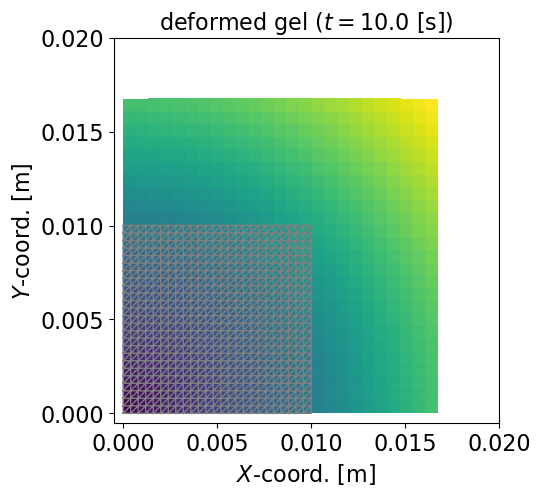

In [14]:
plt.figure(figsize=(6,5))
p = plot(u, mode="displacement")
plt.xlim((-0.0005, 0.02))
plt.ylim((-0.0005, 0.02))
plot(mesh, linewidth=1.0)
# cbar = plt.colorbar(p, format="%.2f")#, shrink = 0.5)
# cbar.ax.tick_params(labelsize=14)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel("$X$-coord. [m]", fontsize=16)
plt.ylabel("$Y$-coord. [m]", fontsize=16)
# plt.legend(["deformed gel"])
plt.title("deformed gel ($t = {:.1f}$ [s])".format(t_current), fontsize = 16)
# plt.savefig('results/Chester/time/Fig_2DFEM_def_gel_x001_bech_{:.1f}_2011.pdf'.format(t_current))
# plt.savefig('results/Chester/time/Fig_2DFEM_def_gel_x001_bech_{:.1f}_2015.pdf'.format(t_current))
plt.show() 

12550


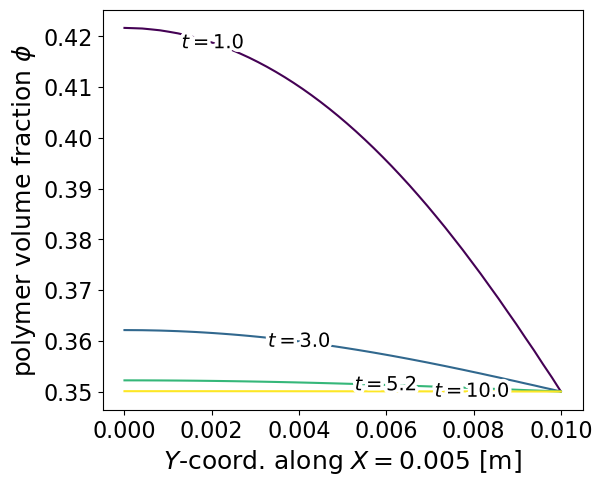

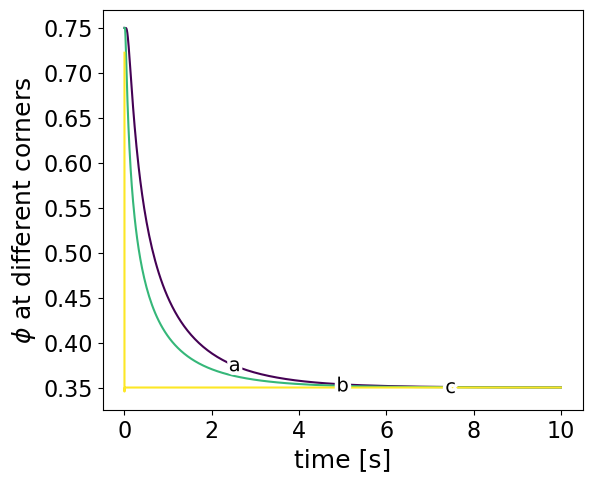

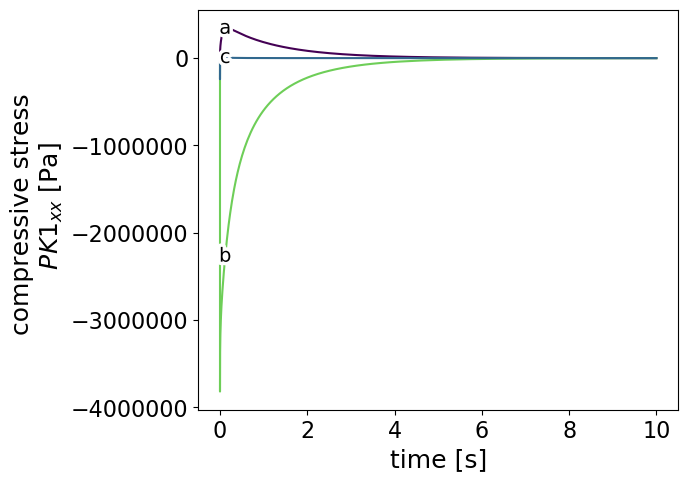

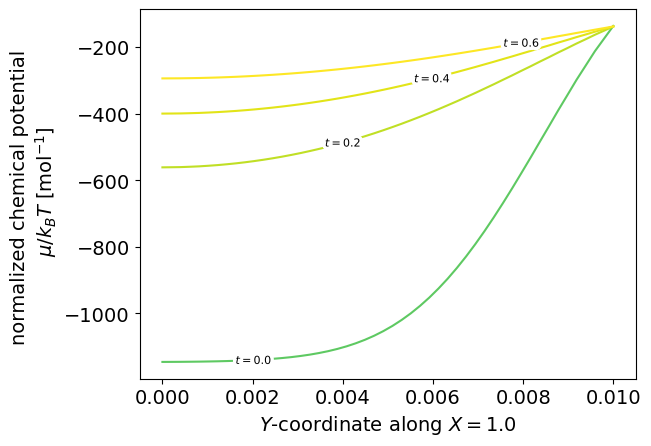

In [15]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[0]

nValues = np.arange(0,4)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis
i = 0
for n in [208,227,237,249]:
    # ax.plot(x, lambda_res[:, n+1], 'k.')
    ax.plot(x, φ_res[:, n+1], color=colormap(normalize(i)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))
    i = i+1

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=18)
ax.set_ylabel("polymer volume fraction $\phi$", fontsize=18)
# ax.legend(["reference 1D sol.", "2D FEM approx."], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda Jx_array, pos: "{:.2f}".format(Jx_array)))

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Chester/Fig_2DFEM_phi_time_2011_x001_v2.pdf')
# plt.savefig('results/Chester/Fig_2DFEM_phi_time_2015_x001_v2.pdf')

# stretch
fig, ax = plt.subplots(figsize=(6,5))

normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

ax.plot(t[1:], φ_0_array[0, 1:], color=colormap(normalize(0)), label="a")
ax.plot(t[1:], φ_05_array[24, 1:], color=colormap(normalize(2)), label="b")
ax.plot(t[1:], φ_L_array[-1, 1:], color=colormap(normalize(3)), label="c")

# xvals = [0.2, 0.2, 0.2]
# labelLines(ax.get_lines(), align=False, xvals=xvals, color="k", fontsize=14)
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14)
ax.set_xlabel("time [s]", fontsize=18)
ax.set_ylabel("$\phi$ at different corners", fontsize=18)
# ax.legend(["bottom-left edge", "bottom-right edge", "top-left edge"], fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Chester/Fig_2DFEM_phi_2011_x001_v2.pdf')
# plt.savefig('results/Chester/Fig_2DFEM_phi_2015_x001_v2.pdf')

# stress
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[2]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

print(PK1xxL_array.size)

ax.plot(t[1:], PK1xx0_array[0, 1:], color=colormap(normalize(0)), label="a")
ax.plot(t[1:], PK1xx0_array[-1, 1:], color=colormap(normalize(7)), label="b")
ax.plot(t[1:], PK1xxL_array[-1, 1:], color=colormap(normalize(3)), label="c")

xvals = [0.12, 0.12, 0.12]
# xvals = [0.2, 0.2, 0.2]
labelLines(ax.get_lines(), align=False, xvals=xvals, color="k", fontsize=14)
ax.set_xlabel("time [s]", fontsize=18)
# ax.set_ylabel("normalized stress at different edges \n $PK1_{xx}/Nk_B T$ [MPa/MPa]", fontsize=14)
ax.set_ylabel("compressive stress \n $PK1_{xx}$ [Pa]", fontsize=18)
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Chester/Fig_2DFEM_PK1_2011_x001.pdf')
# plt.savefig('results/Chester/Fig_2DFEM_PK1_2015_x001.pdf')
plt.show()

# chemical potential
fig, ax = plt.subplots()

nValues = np.arange(0,200)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

for n in [150,180,190,199]:
    ax.plot(x, (1.3806488e-23*298)*µ_res[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=8)
ax.set_xlabel("$Y$-coordinate along $X=1.0$", fontsize=14)
ax.set_ylabel("normalized chemical potential \n $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

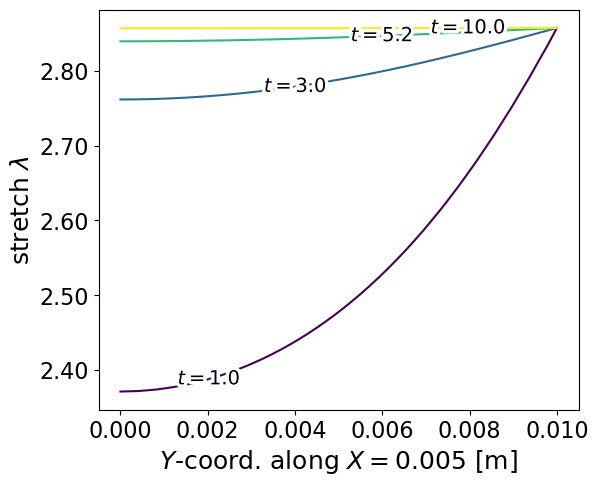

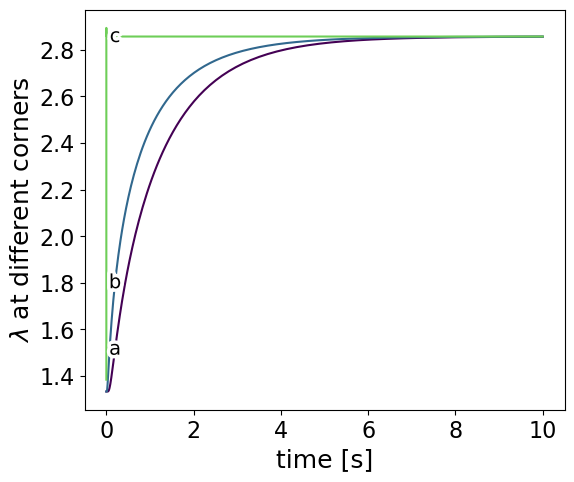

In [16]:
# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[0]

nValues = np.arange(0,4)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis
i = 0
for n in [208,227,237,249]:
    ax.plot(x, 1/φ_res[:, n+1], color=colormap(normalize(i)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))
    i = i + 1

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=18)
ax.set_ylabel("stretch $\lambda$", fontsize=18)
# ax.legend(["reference 1D sol.", "2D FEM approx."], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda Jx_array, pos: "{:.2f}".format(Jx_array)))

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Chester/Fig_2DFEM_stretch_time_2011_x001_bench_v2.pdf')
# plt.savefig('results/Chester/Fig_2DFEM_stretch_time_2015_x001_bench_v2.pdf')

# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[1]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

ax.plot(t[1:], 1/φ_0_array[0, 1:], color=colormap(normalize(0)), label="a")
ax.plot(t[1:], 1/φ_05_array[24, 1:], color=colormap(normalize(3)), label="b")
ax.plot(t[1:], 1/φ_L_array[-1, 1:], color=colormap(normalize(7)), label="c")

# for n in nValues:
#     ax.plot(t[1:], lambda_array[n+1, 1:], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))

xvals = [0.2, 0.2, 0.2]
labelLines(ax.get_lines(), align=False, xvals=xvals, color="k", fontsize=14)
ax.set_xlabel("time [s]", fontsize=18)
ax.set_ylabel("$\lambda$ at different corners", fontsize=18)
# ax.legend(["bottom-left edge", "bottom-right edge", "top-left edge"], fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Chester/Fig_2DFEM_stretch_2011_x001_bench_v2.pdf')
# plt.savefig('results/Chester/Fig_2DFEM_stretch_2015_x001_bench_v2.pdf')